# Load a test split

In [1]:
import os
import json
split_num=5
data_dir = "."
label_file = os.path.join(data_dir, f"testset_split_{split_num}_rawframes.txt")
prob_files = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(f"_split{split_num}.json"):
            prob_files.append(os.path.join(root, file))
prob_files

In [2]:
import numpy as np
participant = []
camera = []
segment = []
GT = []
with open(label_file, "r") as f:
    for line in f:
        labels_raw = line.strip().split(" ")
        participant.append(labels_raw[0].split("_")[1])
        camera.append(labels_raw[0].split("_")[3])
        segment.append(labels_raw[0].split("_")[7])
        GT.append(int(labels_raw[2]))
labels_raw = np.array(labels_raw)
probs = []
probs_flow = []
probs_rgb = []
for prob_file in prob_files:
    if ("flow" in prob_file):
        probs_flow.append(json.load(open(prob_file, "r")))
    elif("rgb" in prob_file):
        probs_rgb.append(json.load(open(prob_file, "r")))

    probs.append(json.load(open(prob_file, "r")))
probs_rgb = np.array(probs_rgb)
probs_flow = np.array(probs_flow)
probs_rgb = np.mean(probs_rgb, axis=0)
probs_flow = np.mean(probs_flow, axis=0)
probs = np.array(probs)
probs_avg = np.mean(probs, axis=0)
# probs_avg.shape

## Merge the predicted results to 1) Average between RGB_FLOW, RGB/Flow Alone

In [4]:
import pandas as pd
prob_avg_RGB_FLOW = pd.DataFrame({
        'Participant': participant,
        'Camera': camera,
        'Segment': segment,
        'Prob 0': probs_avg[:, 0], ## Other prob
        'Prob 1': probs_avg[:, 1],## EyeContact prob
        'GT': GT
})
prob_single_RGB = pd.DataFrame({
        'Participant': participant,
        'Camera': camera,
        'Segment': segment,
        'Prob 0': probs_rgb[:, 0], ## Other prob
        'Prob 1': probs_rgb[:, 1],## EyeContact prob
        'GT': GT
})
prob_single_FLOW = pd.DataFrame({
        'Participant': participant,
        'Camera': camera,
        'Segment': segment,
        'Prob 0': probs_flow[:, 0], ## Other prob
        'Prob 1': probs_flow[:, 1],## EyeContact prob
        'GT': GT
})


### Multiview on RGB Only

In [5]:
data_participant_segment_rgb = prob_single_RGB.groupby(["Participant","Segment","GT"]).agg(
                                {
                                    'Camera': list,
                                    'Prob 0': np.mean,
                                    'Prob 1': np.mean
                                })
data_participant_segment_rgb['Pred'] = np.where(data_participant_segment_rgb['Prob 0'] > data_participant_segment_rgb['Prob 1'], 
                                                0, 1)
data_participant_segment_rgb


Camera    Prob 0        Prob 1  Pred
Participant Segment GT                                                
Autism0043  1       0   [C4, C1, C3, C2]  1.000000  2.052426e-09     0
            2       0   [C1, C3, C2, C4]  1.000000  4.308524e-08     0
            3       0   [C2, C1, C4, C3]  0.999998  2.044282e-06     0
Autism0044  1       0   [C4, C2, C3, C1]  0.999656  3.443353e-04     0
Autism0045  1       0   [C3, C4, C1, C2]  0.812717  1.872829e-01     0
...                                  ...       ...           ...   ...
Control0032 6       0   [C3, C4, C2, C1]  1.000000  2.107425e-07     0
            7       0   [C3, C4, C1, C2]  0.999743  2.570823e-04     0
            8       0   [C3, C4, C2, C1]  0.999999  5.604720e-07     0
Control0033 1       0   [C2, C3, C1, C4]  0.999974  2.634982e-05     0
            2       0   [C4, C1, C2, C3]  1.000000  2.941414e-10     0

[647 rows x 4 columns]

### Multiview on Flow Only

In [6]:
data_participant_segment_flow = prob_single_FLOW.groupby(["Participant","Segment","GT"]).agg(
                                {
                                    'Camera': list,
                                    'Prob 0': np.mean,
                                    'Prob 1': np.mean
                                })
data_participant_segment_flow['Pred'] = np.where(data_participant_segment_flow['Prob 0'] > data_participant_segment_flow['Prob 1'], 
                                                0, 1)
data_participant_segment_flow

Camera    Prob 0    Prob 1  Pred
Participant Segment GT                                            
Autism0043  1       0   [C4, C1, C3, C2]  0.947808  0.052192     0
            2       0   [C1, C3, C2, C4]  0.795247  0.204753     0
            3       0   [C2, C1, C4, C3]  0.947803  0.052197     0
Autism0044  1       0   [C4, C2, C3, C1]  0.643809  0.356191     0
Autism0045  1       0   [C3, C4, C1, C2]  0.657856  0.342144     0
...                                  ...       ...       ...   ...
Control0032 6       0   [C3, C4, C2, C1]  0.957383  0.042617     0
            7       0   [C3, C4, C1, C2]  0.558332  0.441668     0
            8       0   [C3, C4, C2, C1]  0.432380  0.567620     1
Control0033 1       0   [C2, C3, C1, C4]  0.890515  0.109485     0
            2       0   [C4, C1, C2, C3]  0.931904  0.068096     0

[647 rows x 4 columns]

### Multiview on Averaged RGB/Flow

In [7]:
data_participant_segment = prob_avg_RGB_FLOW.groupby(["Participant","Segment","GT"]).agg(
                                {
                                    'Camera': list,
                                    'Prob 0': np.mean,
                                    'Prob 1': np.mean
                                })
data_participant_segment['Pred'] = np.where(data_participant_segment['Prob 0'] > data_participant_segment['Prob 1'], 
                                                0, 1)
data_participant_segment


Camera    Prob 0    Prob 1  Pred
Participant Segment GT                                            
Autism0043  1       0   [C4, C1, C3, C2]  0.973904  0.026096     0
            2       0   [C1, C3, C2, C4]  0.897623  0.102377     0
            3       0   [C2, C1, C4, C3]  0.973901  0.026099     0
Autism0044  1       0   [C4, C2, C3, C1]  0.821733  0.178267     0
Autism0045  1       0   [C3, C4, C1, C2]  0.735287  0.264713     0
...                                  ...       ...       ...   ...
Control0032 6       0   [C3, C4, C2, C1]  0.978692  0.021308     0
            7       0   [C3, C4, C1, C2]  0.779037  0.220963     0
            8       0   [C3, C4, C2, C1]  0.716190  0.283810     0
Control0033 1       0   [C2, C3, C1, C4]  0.945244  0.054756     0
            2       0   [C4, C1, C2, C3]  0.965952  0.034048     0

[647 rows x 4 columns]

## Save the predictions into excel

In [8]:
# multiview RGB Channel
output = os.path.join(data_dir, f"baseline_result_multiview_RGB_channel_split_{split_num}.xlsx")
data_participant_segment_rgb.to_excel(output)

In [9]:
# multiview Flow Channel
output = os.path.join(data_dir, f"baseline_result_multiview_Flow_channel_split_{split_num}.xlsx")
data_participant_segment_flow.to_excel(output)

In [10]:
# multiview fusion
output = os.path.join(data_dir, f"baseline_result_multiview_fusion_split_{split_num}.xlsx")
data_participant_segment.to_excel(output)

In [11]:
#single view RGB
prob_single_RGB['Pred'] = np.where(prob_single_RGB['Prob 0'] > prob_single_RGB['Prob 1'], 
                                                0, 1)
output_single = os.path.join(data_dir, f"baseline_result_singleview_RGB_split_{split_num}.xlsx")
prob_single_RGB.to_excel(output_single)

In [12]:
#single view Flow
prob_single_FLOW['Pred'] = np.where(prob_single_FLOW['Prob 0'] > prob_single_FLOW['Prob 1'], 
                                                0, 1)
output_single = os.path.join(data_dir, f"baseline_result_singleview_Flow_split_{split_num}.xlsx")
prob_single_FLOW.to_excel(output_single)

In [13]:
#single view fusion
prob_avg_RGB_FLOW['Pred'] = np.where(prob_avg_RGB_FLOW['Prob 0'] > prob_avg_RGB_FLOW['Prob 1'], 
                                                0, 1)
output_single = os.path.join(data_dir, f"baseline_result_singleview_fusion_split_{split_num}.xlsx")
prob_avg_RGB_FLOW.to_excel(output_single)

# Single View Performance

In [14]:
import pandas as pd

results_table_single_rgb = pd.read_excel (os.path.join(data_dir, f"baseline_result_singleview_RGB_split_{split_num}.xlsx"))
results_table_single_flow = pd.read_excel (os.path.join(data_dir, f"baseline_result_singleview_Flow_split_{split_num}.xlsx"))
results_table_single_fusion = pd.read_excel (os.path.join(data_dir, f"baseline_result_singleview_fusion_split_{split_num}.xlsx"))

In [15]:
results_table_single_rgb_cc = results_table_single_rgb[results_table_single_rgb["Participant"].str.contains('Control')]
results_table_single_rgb_cc
results_table_single_rgb_asd = results_table_single_rgb[results_table_single_rgb["Participant"].str.contains('Autism')]
results_table_single_rgb_asd

results_table_single_flow_cc = results_table_single_flow[results_table_single_flow["Participant"].str.contains('Control')]
results_table_single_flow_cc
results_table_single_flow_asd = results_table_single_flow[results_table_single_flow["Participant"].str.contains('Autism')]
results_table_single_flow_asd

results_table_single_fusion_cc = results_table_single_fusion[results_table_single_fusion["Participant"].str.contains('Control')]
results_table_single_fusion_cc
results_table_single_fusion_asd = results_table_single_fusion[results_table_single_fusion["Participant"].str.contains('Autism')]
results_table_single_fusion_asd

,Unnamed: 0,Participant,Camera,Segment,Prob 0,Prob 1,GT,Pred
0,0,Autism0106,C3,1,0.964886,0.035114,0,0
1,1,Autism0105,C1,1,0.608883,0.391117,0,0
2,2,Autism0106,C1,1,0.251372,0.748628,1,1
3,3,Autism0096,C3,3,0.818309,0.181691,1,0
6,6,Autism0069,C3,1,0.988036,0.011964,0,0
...,...,...,...,...,...,...,...,...
2541,2541,Autism0096,C2,1,0.081623,0.918377,1,1
2542,2542,Autism0104,C4,5,0.994781,0.005219,0,0
2546,2546,Autism0099,C2,14,0.635894,0.364106,0,0
2548,2548,Autism0049,C1,1,0.004570,0.995430,1,1


In [16]:
from sklearn.metrics import accuracy_score
y_true_single_rgb = results_table_single_rgb["GT"]
y_pred_single_rgb = results_table_single_rgb["Pred"]
print(accuracy_score(y_true_single_rgb, y_pred_single_rgb))

y_true_single_flow = results_table_single_flow["GT"]
y_pred_single_flow = results_table_single_flow["Pred"]
print(accuracy_score(y_true_single_flow, y_pred_single_flow))

y_true_single_fusion = results_table_single_fusion["GT"]
y_pred_single_fusion = results_table_single_fusion["Pred"]
print(accuracy_score(y_true_single_fusion, y_pred_single_fusion))

0.8690709525676206
0.791062328498628
0.8902391219129753


In [17]:
from sklearn.metrics import accuracy_score
y_true_single_rgb_cc = results_table_single_rgb_cc["GT"]
y_pred_single_rgb_cc = results_table_single_rgb_cc["Pred"]
print(accuracy_score(y_true_single_rgb_cc, y_pred_single_rgb_cc))
y_true_single_rgb_asd = results_table_single_rgb_asd["GT"]
y_pred_single_rgb_asd = results_table_single_rgb_asd["Pred"]
print(accuracy_score(y_true_single_rgb_asd, y_pred_single_rgb_asd))

y_true_single_flow_cc = results_table_single_flow_cc["GT"]
y_pred_single_flow_cc = results_table_single_flow_cc["Pred"]
print(accuracy_score(y_true_single_flow_cc, y_pred_single_flow_cc))
y_true_single_flow_asd = results_table_single_flow_asd["GT"]
y_pred_single_flow_asd = results_table_single_flow_asd["Pred"]
print(accuracy_score(y_true_single_flow_asd, y_pred_single_flow_asd))

y_true_single_fusion_cc = results_table_single_fusion_cc["GT"]
y_pred_single_fusion_cc = results_table_single_fusion_cc["Pred"]
print(accuracy_score(y_true_single_fusion_cc, y_pred_single_fusion_cc))
y_true_single_fusion_asd = results_table_single_fusion_asd["GT"]
y_pred_single_fusion_asd = results_table_single_fusion_asd["Pred"]
print(accuracy_score(y_true_single_fusion_asd, y_pred_single_fusion_asd))

0.8493788819875776
0.875721027792344
0.8260869565217391
0.7792343995804929
0.8835403726708074
0.8925013109596225


In [18]:
from sklearn import metrics

report_single_rgb = metrics.classification_report(y_true_single_rgb,y_pred_single_rgb,digits=3,output_dict=True)
print(report_single_rgb)

report_single_flow = metrics.classification_report(y_true_single_flow, y_pred_single_flow,digits=3,output_dict=True)
print(report_single_flow)

report_single_fusion = metrics.classification_report(y_true_single_fusion, y_pred_single_fusion,digits=3,output_dict=True)
print(report_single_fusion)

{'0': {'precision': 0.882744836775483, 'recall': 0.8934592043155766, 'f1-score': 0.8880697050938339, 'support': 1483}, '1': {'precision': 0.8495238095238096, 'recall': 0.8352059925093633, 'f1-score': 0.8423040604343721, 'support': 1068}, 'accuracy': 0.8690709525676206, 'macro avg': {'precision': 0.8661343231496463, 'recall': 0.8643325984124699, 'f1-score': 0.8651868827641029, 'support': 2551}, 'weighted avg': {'precision': 0.8688365431240571, 'recall': 0.8690709525676206, 'f1-score': 0.8689094900815622, 'support': 2551}}
{'0': {'precision': 0.8457059679767104, 'recall': 0.7835468644639245, 'f1-score': 0.8134406720336018, 'support': 1483}, '1': {'precision': 0.7272727272727273, 'recall': 0.8014981273408239, 'f1-score': 0.7625835189309577, 'support': 1068}, 'accuracy': 0.791062328498628, 'macro avg': {'precision': 0.7864893476247188, 'recall': 0.7925224959023742, 'f1-score': 0.7880120954822798, 'support': 2551}, 'weighted avg': {'precision': 0.7961227844910758, 'recall': 0.79106232849862

In [19]:
from sklearn import metrics

report_single_rgb_cc = metrics.classification_report(y_true_single_rgb_cc,y_pred_single_rgb_cc,digits=3,output_dict=True)
print(report_single_rgb_cc)
report_single_rgb_asd = metrics.classification_report(y_true_single_rgb_asd,y_pred_single_rgb_asd,digits=3,output_dict=True)
print(report_single_rgb_asd)

report_single_flow_cc = metrics.classification_report(y_true_single_flow_cc, y_pred_single_flow_cc,digits=3,output_dict=True)
print(report_single_flow_cc)
report_single_flow_asd = metrics.classification_report(y_true_single_flow_asd, y_pred_single_flow_asd,digits=3,output_dict=True)
print(report_single_flow_asd)

report_single_fusion_cc = metrics.classification_report(y_true_single_fusion_cc, y_pred_single_fusion_cc,digits=3,output_dict=True)
print(report_single_fusion_cc)
report_single_fusion_asd = metrics.classification_report(y_true_single_fusion_asd, y_pred_single_fusion_asd,digits=3,output_dict=True)
print(report_single_fusion_asd)

{'0': {'precision': 0.8796992481203008, 'recall': 0.8775, 'f1-score': 0.8785982478097621, 'support': 400}, '1': {'precision': 0.8, 'recall': 0.8032786885245902, 'f1-score': 0.8016359918200409, 'support': 244}, 'accuracy': 0.8493788819875776, 'macro avg': {'precision': 0.8398496240601504, 'recall': 0.8403893442622951, 'f1-score': 0.8401171198149016, 'support': 644}, 'weighted avg': {'precision': 0.8495026385840377, 'recall': 0.8493788819875776, 'f1-score': 0.8494386352919174, 'support': 644}}
{'0': {'precision': 0.8838475499092558, 'recall': 0.8993536472760849, 'f1-score': 0.891533180778032, 'support': 1083}, '1': {'precision': 0.8645962732919255, 'recall': 0.8446601941747572, 'f1-score': 0.85451197053407, 'support': 824}, 'accuracy': 0.875721027792344, 'macro avg': {'precision': 0.8742219116005907, 'recall': 0.8720069207254211, 'f1-score': 0.873022575656051, 'support': 1907}, 'weighted avg': {'precision': 0.8755292216802678, 'recall': 0.875721027792344, 'f1-score': 0.8755366012074894, 

# Multiview Performance

## Multiview RGB

In [20]:
import pandas as pd

multiview_rgb = pd.read_excel (os.path.join(data_dir, f"baseline_result_multiview_RGB_channel_split_{split_num}.xlsx"))
multiview_rgb = multiview_rgb.fillna(method='ffill', axis=0)

results_table_multiview_rgb =multiview_rgb[["Pred","GT"]]

In [21]:
results_table_multiview_rgb_cc = multiview_rgb[multiview_rgb["Participant"].str.contains('Control')]
results_table_multiview_rgb_cc
results_table_multiview_rgb_asd = multiview_rgb[multiview_rgb["Participant"].str.contains('Autism')]
results_table_multiview_rgb_asd

,Participant,Segment,GT,Camera,Prob 0,Prob 1,Pred
0,Autism0043,1.0,0,"['C4', 'C1', 'C3', 'C2']",1.000000,2.052426e-09,0
1,Autism0043,2.0,0,"['C1', 'C3', 'C2', 'C4']",1.000000,4.308524e-08,0
2,Autism0043,3.0,0,"['C2', 'C1', 'C4', 'C3']",0.999998,2.044282e-06,0
3,Autism0044,1.0,0,"['C4', 'C2', 'C3', 'C1']",0.999656,3.443353e-04,0
4,Autism0045,1.0,0,"['C3', 'C4', 'C1', 'C2']",0.812717,1.872829e-01,0
...,...,...,...,...,...,...,...
481,Autism0107,2.0,0,"['C4', 'C1', 'C2', 'C3']",0.830748,1.692522e-01,0
482,Autism0107,3.0,0,"['C2', 'C4', 'C3', 'C1']",0.997199,2.801441e-03,0
483,Autism0107,3.0,1,"['C1', 'C4', 'C2', 'C3']",0.012284,9.877161e-01,1
484,Autism0107,4.0,0,"['C4', 'C2', 'C1', 'C3']",0.909149,9.085089e-02,0


In [22]:
from sklearn.metrics import accuracy_score
y_true_multiview_rgb = results_table_multiview_rgb["GT"]
y_pred_multiview_rgb = results_table_multiview_rgb["Pred"]
accuracy_score(y_true_multiview_rgb, y_pred_multiview_rgb)

0.9366306027820711

In [23]:
from sklearn.metrics import accuracy_score
y_true_multiview_rgb_cc = results_table_multiview_rgb_cc["GT"]
y_pred_multiview_rgb_cc = results_table_multiview_rgb_cc["Pred"]
accuracy_score(y_true_multiview_rgb_cc, y_pred_multiview_rgb_cc)

0.9130434782608695

In [24]:
y_true_multiview_rgb_asd = results_table_multiview_rgb_asd["GT"]
y_pred_multiview_rgb_asd = results_table_multiview_rgb_asd["Pred"]
accuracy_score(y_true_multiview_rgb_asd, y_pred_multiview_rgb_asd)

0.9444444444444444

In [25]:
from sklearn.metrics import precision_recall_curve
y_prob1_multiview_rgb= multiview_rgb["Prob 1"]
precision, recall, thresholds = precision_recall_curve(y_true_multiview_rgb, y_pred_multiview_rgb)
recall

array([1.        , 0.93357934, 0.        ])

In [26]:
from sklearn import metrics

report_multiview_rgb = metrics.classification_report(y_true_multiview_rgb,y_pred_multiview_rgb,digits=3,output_dict=True)
print(report_multiview_rgb)
report_multiview_rgb_cc = metrics.classification_report(y_true_multiview_rgb_cc,y_pred_multiview_rgb_cc,digits=3,output_dict=True)
print(report_multiview_rgb_cc)
report_multiview_rgb_asd = metrics.classification_report(y_true_multiview_rgb_asd,y_pred_multiview_rgb_asd,digits=3,output_dict=True)
print(report_multiview_rgb_asd)


{'0': {'precision': 0.9514824797843666, 'recall': 0.9388297872340425, 'f1-score': 0.9451137884872826, 'support': 376}, '1': {'precision': 0.9166666666666666, 'recall': 0.933579335793358, 'f1-score': 0.9250457038391225, 'support': 271}, 'accuracy': 0.9366306027820711, 'macro avg': {'precision': 0.9340745732255167, 'recall': 0.9362045615137002, 'f1-score': 0.9350797461632026, 'support': 647}, 'weighted avg': {'precision': 0.9368996585248663, 'recall': 0.9366306027820711, 'f1-score': 0.9367081456130145, 'support': 647}}
{'0': {'precision': 0.93, 'recall': 0.93, 'f1-score': 0.93, 'support': 100}, '1': {'precision': 0.8852459016393442, 'recall': 0.8852459016393442, 'f1-score': 0.8852459016393442, 'support': 61}, 'accuracy': 0.9130434782608695, 'macro avg': {'precision': 0.9076229508196721, 'recall': 0.9076229508196721, 'f1-score': 0.9076229508196721, 'support': 161}, 'weighted avg': {'precision': 0.9130434782608695, 'recall': 0.9130434782608695, 'f1-score': 0.9130434782608695, 'support': 16

## Multiview Flow

In [27]:
multiview_flow = pd.read_excel (os.path.join(data_dir, f"baseline_result_multiview_Flow_channel_split_{split_num}.xlsx"))
multiview_flow = multiview_flow.fillna(method='ffill', axis=0)

results_table_multiview_flow =multiview_flow[["Pred","GT"]]
results_table_multiview_flow

,Pred,GT
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
642,0,0
643,0,0
644,1,0
645,0,0


In [28]:
results_table_multiview_flow_cc = multiview_flow[multiview_flow["Participant"].str.contains('Control')]
results_table_multiview_flow_cc
results_table_multiview_flow_asd = multiview_flow[multiview_flow["Participant"].str.contains('Autism')]
results_table_multiview_flow_asd

,Participant,Segment,GT,Camera,Prob 0,Prob 1,Pred
0,Autism0043,1.0,0,"['C4', 'C1', 'C3', 'C2']",0.947808,0.052192,0
1,Autism0043,2.0,0,"['C1', 'C3', 'C2', 'C4']",0.795247,0.204753,0
2,Autism0043,3.0,0,"['C2', 'C1', 'C4', 'C3']",0.947803,0.052197,0
3,Autism0044,1.0,0,"['C4', 'C2', 'C3', 'C1']",0.643809,0.356191,0
4,Autism0045,1.0,0,"['C3', 'C4', 'C1', 'C2']",0.657856,0.342144,0
...,...,...,...,...,...,...,...
481,Autism0107,2.0,0,"['C4', 'C1', 'C2', 'C3']",0.224978,0.775022,1
482,Autism0107,3.0,0,"['C2', 'C4', 'C3', 'C1']",0.985501,0.014499,0
483,Autism0107,3.0,1,"['C1', 'C4', 'C2', 'C3']",0.417676,0.582324,1
484,Autism0107,4.0,0,"['C4', 'C2', 'C1', 'C3']",0.919822,0.080178,0


In [29]:
from sklearn.metrics import accuracy_score
y_true_multiview_flow = results_table_multiview_flow["GT"]
y_pred_multiview_flow = results_table_multiview_flow["Pred"]
accuracy_score(y_true_multiview_flow, y_pred_multiview_flow)

0.8763523956723338

In [30]:
from sklearn.metrics import accuracy_score
y_true_multiview_flow_cc = results_table_multiview_flow_cc["GT"]
y_pred_multiview_flow_cc = results_table_multiview_flow_cc["Pred"]
accuracy_score(y_true_multiview_flow_cc, y_pred_multiview_flow_cc)

0.906832298136646

In [31]:
from sklearn.metrics import accuracy_score
y_true_multiview_flow_asd = results_table_multiview_flow_asd["GT"]
y_pred_multiview_flow_asd = results_table_multiview_flow_asd["Pred"]
accuracy_score(y_true_multiview_flow_asd, y_pred_multiview_flow_asd)

0.8662551440329218

In [32]:
from sklearn.metrics import precision_recall_curve
y_prob1_multiview_flow= multiview_flow["Prob 1"]
precision, recall, thresholds = precision_recall_curve(y_true_multiview_flow, y_pred_multiview_flow)
recall

array([1.        , 0.88191882, 0.        ])

In [33]:
from sklearn import metrics

report_multiview_flow = metrics.classification_report(y_true_multiview_flow,y_pred_multiview_flow,digits=3,output_dict=True)
print(report_multiview_flow)
report_multiview_flow_cc = metrics.classification_report(y_true_multiview_flow_cc,y_pred_multiview_flow_cc,digits=3,output_dict=True)
print(report_multiview_flow_cc)
report_multiview_flow_asd = metrics.classification_report(y_true_multiview_flow_asd,y_pred_multiview_flow_asd,digits=3,output_dict=True)
print(report_multiview_flow_asd)


{'0': {'precision': 0.9111111111111111, 'recall': 0.8723404255319149, 'f1-score': 0.891304347826087, 'support': 376}, '1': {'precision': 0.8327526132404182, 'recall': 0.8819188191881919, 'f1-score': 0.8566308243727598, 'support': 271}, 'accuracy': 0.8763523956723338, 'macro avg': {'precision': 0.8719318621757646, 'recall': 0.8771296223600534, 'f1-score': 0.8739675860994234, 'support': 647}, 'weighted avg': {'precision': 0.878290163780419, 'recall': 0.8763523956723338, 'f1-score': 0.8767811254831942, 'support': 647}}
{'0': {'precision': 0.9381443298969072, 'recall': 0.91, 'f1-score': 0.9238578680203046, 'support': 100}, '1': {'precision': 0.859375, 'recall': 0.9016393442622951, 'f1-score': 0.88, 'support': 61}, 'accuracy': 0.906832298136646, 'macro avg': {'precision': 0.8987596649484536, 'recall': 0.9058196721311476, 'f1-score': 0.9019289340101523, 'support': 161}, 'weighted avg': {'precision': 0.9083000496254082, 'recall': 0.906832298136646, 'f1-score': 0.9072409118138538, 'support': 1

## Multiview Fusion

In [34]:
multiview_fusion = pd.read_excel (os.path.join(data_dir, f"baseline_result_multiview_fusion_split_{split_num}.xlsx"))
multiview_fusion = multiview_fusion.fillna(method='ffill', axis=0)

results_table_multiview_fusion=multiview_fusion[["Pred","GT"]]
results_table_multiview_fusion

,Pred,GT
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
642,0,0
643,0,0
644,0,0
645,0,0


In [35]:
results_table_multiview_fusion_cc = multiview_fusion[multiview_fusion["Participant"].str.contains('Control')]
results_table_multiview_fusion_cc
results_table_multiview_fusion_asd = multiview_fusion[multiview_fusion["Participant"].str.contains('Autism')]
results_table_multiview_fusion_asd

,Participant,Segment,GT,Camera,Prob 0,Prob 1,Pred
0,Autism0043,1.0,0,"['C4', 'C1', 'C3', 'C2']",0.973904,0.026096,0
1,Autism0043,2.0,0,"['C1', 'C3', 'C2', 'C4']",0.897623,0.102377,0
2,Autism0043,3.0,0,"['C2', 'C1', 'C4', 'C3']",0.973901,0.026099,0
3,Autism0044,1.0,0,"['C4', 'C2', 'C3', 'C1']",0.821733,0.178267,0
4,Autism0045,1.0,0,"['C3', 'C4', 'C1', 'C2']",0.735287,0.264713,0
...,...,...,...,...,...,...,...
481,Autism0107,2.0,0,"['C4', 'C1', 'C2', 'C3']",0.527863,0.472137,0
482,Autism0107,3.0,0,"['C2', 'C4', 'C3', 'C1']",0.991350,0.008650,0
483,Autism0107,3.0,1,"['C1', 'C4', 'C2', 'C3']",0.214980,0.785020,1
484,Autism0107,4.0,0,"['C4', 'C2', 'C1', 'C3']",0.914486,0.085514,0


In [36]:
from sklearn.metrics import accuracy_score
y_true_multiview_fusion = results_table_multiview_fusion["GT"]
y_pred_multiview_fusion = results_table_multiview_fusion["Pred"]
accuracy_score(y_true_multiview_fusion, y_pred_multiview_fusion)

0.9520865533230294

In [37]:
from sklearn.metrics import accuracy_score
y_true_multiview_fusion_cc = results_table_multiview_fusion_cc["GT"]
y_pred_multiview_fusion_cc = results_table_multiview_fusion_cc["Pred"]
accuracy_score(y_true_multiview_fusion_cc, y_pred_multiview_fusion_cc)

0.9316770186335404

In [38]:
from sklearn.metrics import accuracy_score
y_true_multiview_fusion_asd = results_table_multiview_fusion_asd["GT"]
y_pred_multiview_fusion_asd = results_table_multiview_fusion_asd["Pred"]
accuracy_score(y_true_multiview_fusion_asd, y_pred_multiview_fusion_asd)

0.9588477366255144

In [39]:
from sklearn.metrics import precision_recall_curve
y_prob1_multiview_fusion= multiview_fusion["Prob 1"]
precision, recall, thresholds = precision_recall_curve(y_true_multiview_fusion, y_pred_multiview_fusion)
recall

array([1.        , 0.96309963, 0.        ])

In [40]:
from sklearn import metrics

report_multiview_fusion = metrics.classification_report(y_true_multiview_fusion,y_pred_multiview_fusion,digits=3,output_dict=True)
print(report_multiview_fusion)
report_multiview_fusion_cc = metrics.classification_report(y_true_multiview_fusion_cc,y_pred_multiview_fusion_cc,digits=3,output_dict=True)
print(report_multiview_fusion_cc)
report_multiview_fusion_asd = metrics.classification_report(y_true_multiview_fusion_asd,y_pred_multiview_fusion_asd,digits=3,output_dict=True)
print(report_multiview_fusion_asd)


{'0': {'precision': 0.9726027397260274, 'recall': 0.9441489361702128, 'f1-score': 0.9581646423751687, 'support': 376}, '1': {'precision': 0.925531914893617, 'recall': 0.9630996309963099, 'f1-score': 0.9439421338155515, 'support': 271}, 'accuracy': 0.9520865533230294, 'macro avg': {'precision': 0.9490673273098222, 'recall': 0.9536242835832613, 'f1-score': 0.9510533880953601, 'support': 647}, 'weighted avg': {'precision': 0.9528868300976143, 'recall': 0.9520865533230294, 'f1-score': 0.9522074556369055, 'support': 647}}
{'0': {'precision': 0.968421052631579, 'recall': 0.92, 'f1-score': 0.9435897435897437, 'support': 100}, '1': {'precision': 0.8787878787878788, 'recall': 0.9508196721311475, 'f1-score': 0.9133858267716536, 'support': 61}, 'accuracy': 0.9316770186335404, 'macro avg': {'precision': 0.9236044657097289, 'recall': 0.9354098360655738, 'f1-score': 0.9284877851806986, 'support': 161}, 'weighted avg': {'precision': 0.9344606575727856, 'recall': 0.9316770186335404, 'f1-score': 0.9321

In [41]:
report_multiview_fusion_asd["0"]["f1-score"]

0.9633699633699634

## Calculate paired sample t-tests

In [42]:
noEC_f1score_five_fold_single_view_RGB = [0.8748829953198128,0.8473282442748091,0.8774002954209749,0.8625267665952892,0.8880697050938339]
EC_f1score_five_fold_single_view_RGB = [0.8472380952380952,0.8163733741392504,0.8033175355450237,0.7922330097087379,0.8423040604343721]

noEC_f1score_five_fold_single_view_flow = [0.8216149831132945,0.8029001074113856,0.8631138975966561,0.8726139462407478,0.8134406720336018]
EC_f1score_five_fold_single_view_flow = [0.7741935483870969,0.6391347099311702,0.742295081967213,0.7509520182787509,0.7625835189309577]

noEC_f1score_five_fold_single_view_fusion = [0.9004329004329004,0.8851371721435031,0.9062049062049062,0.9045848822800495,0.9055967633175994]
EC_f1score_five_fold_single_view_fusion = [0.8759630200308165,0.8439164276935681,0.8399014778325122,0.8416723783413297,0.8689138576779026]

noEC_f1score_five_fold_multiple_view_RGB = [0.9395807644882861,0.9188514357053682,0.9479940564635958,0.92,0.9451137884872826]
EC_f1score_five_fold_multiple_view_RGB = [0.9271916790490341,0.9019607843137255,0.920273348519362,0.8743455497382199,0.9250457038391225]

noEC_f1score_five_fold_multiple_view_flow = [0.8870192307692308,0.8226804123711341,0.8864569083447332,0.9162861491628616,0.891304347826087]
EC_f1score_five_fold_multiple_view_flow = [0.9361702127659575,0.6518218623481781,0.7821522309711287,0.8307692307692308,0.8566308243727598]

noEC_f1score_five_fold_multiple_view_fusion = [0.9544895448954489,0.9221698113207547,0.9433962264150944,0.9472,0.9581646423751687]
EC_f1score_five_fold_multiple_view_fusion = [0.9448584202682564,0.8928571428571429,0.9078014184397162,0.907563025210084,0.9439421338155515]

In [43]:
# !pip install --upgrade scipy

import scipy as sp
print(sp.stats.ttest_rel(noEC_f1score_five_fold_single_view_RGB,noEC_f1score_five_fold_multiple_view_RGB,alternative ="two-sided"))
print(sp.stats.ttest_rel(noEC_f1score_five_fold_single_view_flow,noEC_f1score_five_fold_multiple_view_flow,alternative ="two-sided"))
print(sp.stats.ttest_rel(noEC_f1score_five_fold_single_view_fusion,noEC_f1score_five_fold_multiple_view_fusion,alternative ="two-sided"))

print(sp.stats.ttest_rel(EC_f1score_five_fold_single_view_RGB,EC_f1score_five_fold_multiple_view_RGB,alternative ="two-sided"))
print(sp.stats.ttest_rel(EC_f1score_five_fold_single_view_flow,EC_f1score_five_fold_multiple_view_flow,alternative ="two-sided"))
print(sp.stats.ttest_rel(EC_f1score_five_fold_single_view_fusion,EC_f1score_five_fold_multiple_view_fusion,alternative ="two-sided"))


Ttest_relResult(statistic=-20.785699983648534, pvalue=3.165343239922201e-05)
Ttest_relResult(statistic=-4.037095433037679, pvalue=0.015641503683163055)
Ttest_relResult(statistic=-12.187188081839514, pvalue=0.0002601902826124643)
Ttest_relResult(statistic=-12.910484565482818, pvalue=0.00020759047117173486)
Ttest_relResult(statistic=-3.0428841264178024, pvalue=0.03829392549580668)
Ttest_relResult(statistic=-14.942878970999804, pvalue=0.00011683086652317685)


In [1]:
#!pip install statannot

# Code used in Publication Plotting boxplots to visualise p-values - Eye Contact or Not Eye Contact


In [45]:
# Plotting boxplots to visualise p-values - Eye Contact or Not Eye Contact
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statannot

my_pal = {"Single-View": "lightblue", "Multiple-Views": "lightgreen"}

## Eye Contact
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.set_style("white")
# plt.ylim(0.6, 1)
### Spatial (RGB)

EC_Single = pd.DataFrame({'Spatial' : np.repeat('Single-View',len(EC_f1score_five_fold_single_view_RGB)),'F1-Score': EC_f1score_five_fold_single_view_RGB})
EC_Multiple = pd.DataFrame({'Spatial' : np.repeat('Multiple-Views',len(EC_f1score_five_fold_multiple_view_RGB)),'F1-Score': EC_f1score_five_fold_multiple_view_RGB})
data =pd.concat([EC_Single,EC_Multiple])
sns.boxplot(x='Spatial', y='F1-Score',data =data, ax=axs[0],palette=my_pal)
axs[0].set_ylim(0.6, 1)
# Set the font weight to bold for all text elements
for item in ([axs[0].xaxis.label, axs[0].yaxis.label] +
             axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[0],
    data = data,
    x = 'Spatial',
    y = 'F1-Score',
    box_pairs=[
        ('Single-View','Multiple-Views')
    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Temporal (FLOW)
sns.set_style("white")
# plt.ylim(0.6, 1)

EC_Single = pd.DataFrame({'Temporal' : np.repeat('Single-View',len(EC_f1score_five_fold_single_view_flow)),'F1-Score': EC_f1score_five_fold_single_view_flow})
EC_Multiple = pd.DataFrame({'Temporal' : np.repeat('Multiple-Views',len(EC_f1score_five_fold_multiple_view_flow)),'F1-Score': EC_f1score_five_fold_multiple_view_flow})
data =pd.concat([EC_Single,EC_Multiple])
sns.boxplot(x='Temporal', y='F1-Score',data =data, ax=axs[1],palette=my_pal)
axs[1].set_ylim(0.6, 1)
for item in ([axs[1].xaxis.label, axs[1].yaxis.label] +
             axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[1],
    data = data,
    x = 'Temporal',
    y = 'F1-Score',
    box_pairs=[
        ('Single-View','Multiple-Views')
    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Fusion
sns.set_style("white")
# plt.ylim(0.6, 1)

EC_Single = pd.DataFrame({'Fusion' : np.repeat('Single-View',len(EC_f1score_five_fold_single_view_fusion)),'F1-Score': EC_f1score_five_fold_single_view_fusion})
EC_Multiple = pd.DataFrame({'Fusion' : np.repeat('Multiple-Views',len(EC_f1score_five_fold_multiple_view_fusion)),'F1-Score': EC_f1score_five_fold_multiple_view_fusion})
data =pd.concat([EC_Single,EC_Multiple])
sns.boxplot(x='Fusion', y='F1-Score',data =data, ax=axs[2],palette=my_pal)
axs[2].set_ylim(0.6, 1)
for item in ([axs[2].xaxis.label, axs[2].yaxis.label] +
             axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[2],
    data = data,
    x = 'Fusion',
    y = 'F1-Score',
    box_pairs=[
        ('Single-View','Multiple-Views')
    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
plt.tight_layout()
plt.savefig(fname="EyeContact_Stats_F1_performancefigure.pdf",dpi=330)
## No Eye Contact
### Spatial (RGB)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.set_style("white")
# plt.ylim(0.6, 1)

noEC_Single = pd.DataFrame({'Spatial' : np.repeat('Single-View',len(noEC_f1score_five_fold_single_view_RGB)),'F1-Score': noEC_f1score_five_fold_single_view_RGB})
noEC_Multiple = pd.DataFrame({'Spatial' : np.repeat('Multiple-Views',len(noEC_f1score_five_fold_multiple_view_RGB)),'F1-Score': noEC_f1score_five_fold_multiple_view_RGB})
data =pd.concat([noEC_Single,noEC_Multiple])
sns.boxplot(x='Spatial', y='F1-Score',data =data, ax=axs[0],palette=my_pal)
for item in ([axs[0].xaxis.label, axs[0].yaxis.label] +
             axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

axs[0].set_ylim(0.6, 1)
statannot.add_stat_annotation(
    axs[0],
    data = data,
    x = 'Spatial',
    y = 'F1-Score',
    box_pairs=[
        ('Single-View','Multiple-Views')
    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Temporal (FLOW)
sns.set_style("white")
# plt.ylim(0.6, 1)

noEC_Single = pd.DataFrame({'Temporal' : np.repeat('Single-View',len(noEC_f1score_five_fold_single_view_flow)),'F1-Score': noEC_f1score_five_fold_single_view_flow})
noEC_Multiple = pd.DataFrame({'Temporal' : np.repeat('Multiple-Views',len(noEC_f1score_five_fold_multiple_view_flow)),'F1-Score': noEC_f1score_five_fold_multiple_view_flow})
data =pd.concat([noEC_Single,noEC_Multiple])
sns.boxplot(x='Temporal', y='F1-Score',data =data, ax=axs[1],palette=my_pal)
for item in ([axs[1].xaxis.label, axs[1].yaxis.label] +
             axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)
axs[1].set_ylim(0.6, 1)
statannot.add_stat_annotation(
    axs[1],
    data = data,
    x = 'Temporal',
    y = 'F1-Score',
    box_pairs=[
        ('Single-View','Multiple-Views')
    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Fusion
sns.set_style("white")
# plt.ylim(0.6, 1)

noEC_Single = pd.DataFrame({'Fusion' : np.repeat('Single-View',len(noEC_f1score_five_fold_single_view_fusion)),'F1-Score': noEC_f1score_five_fold_single_view_fusion})
noEC_Multiple = pd.DataFrame({'Fusion' : np.repeat('Multiple-Views',len(noEC_f1score_five_fold_multiple_view_fusion)),'F1-Score': noEC_f1score_five_fold_multiple_view_fusion})
data =pd.concat([noEC_Single,noEC_Multiple])
sns.boxplot(x='Fusion', y='F1-Score',data =data, ax=axs[2],palette=my_pal)
for item in ([axs[2].xaxis.label, axs[2].yaxis.label] +
             axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)
axs[2].set_ylim(0.6, 1)
statannot.add_stat_annotation(
    axs[2],
    data = data,
    x = 'Fusion',
    y = 'F1-Score',
    box_pairs=[
        ('Single-View','Multiple-Views')
    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
plt.tight_layout()
plt.savefig(fname="NoEyeContact_Stats_F1_performancefigure.pdf",dpi=330)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single-View v.s. Multiple-Views: t-test paired samples with Bonferroni correction, P_val=2.076e-04 stat=-1.291e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single-View v.s. Multiple-Views: t-test paired samples with Bonferroni correction, P_val=3.829e-02 stat=-3.043e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single-View v.s. Multiple-Views: t-test paired samples with Bonferroni correction, P_val=1.168e-04 stat=-1.494e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04


## Code for boxplot Eye Contact/Other F1score (ASD/CC)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Multiple-Views_TD v.s. Multiple-Views_ASD: t-test paired samples with Bonferroni correction, P_val=2.746e-01 stat=-2.474e+00
Single-View_TD v.s. Single-View_ASD: t-test paired samples with Bonferroni correction, P_val=6.186e-02 stat=-4.051e+00
Single-View_ASD v.s. Multiple-Views_ASD: t-test paired samples with Bonferroni correction, P_val=6.040e-04 stat=-1.400e+01
Single-View_TD v.s. Multiple-Views_TD: t-test paired samples with Bonferroni correction, P_val=5.221e-03 stat=-8.030e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Multiple-Views_TD v.s. Multiple-Views_ASD: t-test paired samples with Bonferroni correction, P_val=9.582e-01 stat=1.381e+00
Single-View_TD v.s. Single-View_ASD: t-test paired samples w

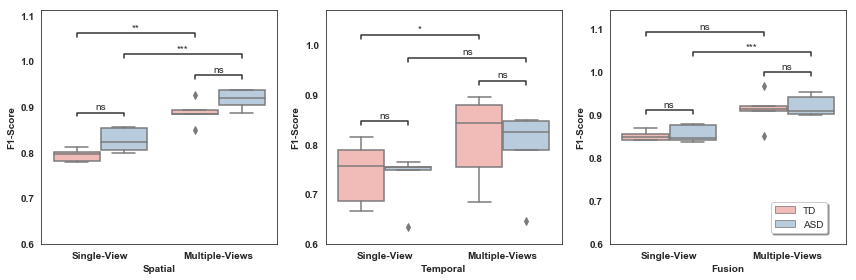

In [46]:
CC_noEC_f1score_five_fold_single_view_RGB = [0.8755129958960328,0.8618421052631577,0.9011976047904192, 0.8600770218228498, 0.8785982478097621]
CC_EC_f1score_five_fold_single_view_RGB = [0.8123711340206186,0.78125,0.7962962962962964,0.7789046653144016, 0.8016359918200409]
ASD_noEC_f1score_five_fold_single_view_RGB = [0.8746968472109944,0.8438485804416404,0.8696078431372549, 0.8637532133676092, 0.891533180778032]
ASD_EC_f1score_five_fold_single_view_RGB = [0.8551401869158879,0.8224215246636772,0.8049853372434018,0.7984790874524715, 0.85451197053407]

CC_noEC_f1score_five_fold_single_view_flow = [ 0.8832214765100672,0.8513119533527698,0.8764044943820224,0.882147024504084,0.8526315789473685 ]
CC_EC_f1score_five_fold_single_view_flow = [0.8152866242038217,0.6666666666666666,0.6857142857142857,0.7566265060240963,0.787878787878788]
ASD_noEC_f1score_five_fold_single_view_flow = [0.803343949044586,0.7919684002633312,0.8587308939323761,0.8678362573099415,0.7992370052455889 ]
ASD_EC_f1score_five_fold_single_view_flow = [0.7649857278782112,0.6342592592592592,0.7550200803212852,0.7483296213808462,0.7548048922539313]

CC_noEC_f1score_five_fold_single_view_fusion = [0.9145183175033921,0.9122257053291536,0.9341142020497804,0.9099876695437731,0.9056603773584907 ]
CC_EC_f1score_five_fold_single_view_fusion = [0.8684759916492694, 0.8418079096045198,0.8543689320388348,0.8416485900216919,0.8478701825557808]
ASD_noEC_f1score_five_fold_single_view_fusion = [0.896275530636764,0.8786860768943636,0.897079942556247,0.9018633540372671,0.90557346844772]
ASD_EC_f1score_five_fold_single_view_fusion = [0.8776570618800189,0.8442740776233829,0.8365019011406843,0.841683366733467,0.8752282410225197]

CC_noEC_f1score_five_fold_multiple_view_RGB = [0.9239130434782609,  0.935897435897436,0.9647058823529412, 0.91,0.93]
CC_EC_f1score_five_fold_multiple_view_RGB = [0.8833333333333334,0.8936170212765957,0.9249999999999999,0.85,0.8852459016393442]
ASD_noEC_f1score_five_fold_multiple_view_RGB = [0.9441786283891547,0.9147286821705426,0.9423459244532805, 0.9249999999999998,0.9506398537477148 ]
ASD_EC_f1score_five_fold_multiple_view_RGB = [0.9367088607594937,0.9033391915641477, 0.9192200557103065,0.885496183206107,0.936470588235294]


CC_noEC_f1score_five_fold_multiple_view_flow = [0.9361702127659575,0.8700564971751412,0.9060773480662985,0.926605504587156,0.9238578680203046]
CC_EC_f1score_five_fold_multiple_view_flow = [0.8965517241379309,0.684931506849315,0.7536231884057971,0.8431372549019608,0.88]
ASD_noEC_f1score_five_fold_multiple_view_flow = [0.8726708074534162, 0.8121059268600251,0.88,0.9111617312072893,0.8794063079777366]
ASD_EC_f1score_five_fold_multiple_view_flow = [0.8470149253731343,0.6460807600950119,0.7884615384615384,0.8251121076233183, 0.8498845265588915]

CC_noEC_f1score_five_fold_multiple_view_fusion = [0.978494623655914, 0.920245398773006,0.9595375722543352,0.9565217391304348,0.9435897435897437]
CC_EC_f1score_five_fold_multiple_view_fusion = [0.9661016949152543,0.8505747126436781,0.9090909090909091,0.9203539823008849,0.9133858267716536]
ASD_noEC_f1score_five_fold_multiple_view_fusion = [0.9473684210526315,0.9226277372262773,0.937984496124031,0.9425837320574162,0.9633699633699634]
ASD_EC_f1score_five_fold_multiple_view_fusion = [0.9403254972875226,0.8998109640831758,0.907514450867052,0.9016393442622952,0.9530516431924883]

## Eye Contact
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.set_style("white")
# plt.ylim(0.6, 1)
### Spatial (RGB)

EC_Single_cc = pd.DataFrame({'class' : np.repeat('TD',len(CC_EC_f1score_five_fold_single_view_RGB)),'Spatial' : np.repeat('Single-View',len(CC_EC_f1score_five_fold_single_view_RGB)),'F1-Score': CC_EC_f1score_five_fold_single_view_RGB})
EC_Multiple_cc= pd.DataFrame({'class' : np.repeat('TD',len(CC_EC_f1score_five_fold_multiple_view_RGB)),'Spatial' : np.repeat('Multiple-Views',len(CC_EC_f1score_five_fold_multiple_view_RGB)),'F1-Score': CC_EC_f1score_five_fold_multiple_view_RGB})
EC_Single_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_EC_f1score_five_fold_single_view_RGB)),'Spatial' : np.repeat('Single-View',len(ASD_EC_f1score_five_fold_single_view_RGB)),'F1-Score': ASD_EC_f1score_five_fold_single_view_RGB})
EC_Multiple_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_EC_f1score_five_fold_multiple_view_RGB)),'Spatial' : np.repeat('Multiple-Views',len(ASD_EC_f1score_five_fold_multiple_view_RGB)),'F1-Score': ASD_EC_f1score_five_fold_multiple_view_RGB})
data =pd.concat([EC_Single_cc,EC_Multiple_cc,EC_Single_asd,EC_Multiple_asd])
sns.boxplot(x='Spatial', y='F1-Score',data =data, ax=axs[0],hue="class",palette="Pastel1")
axs[0].set_ylim(0.6, 1)
# Set the font weight to bold for all text elements
for item in ([axs[0].xaxis.label, axs[0].yaxis.label] +
             axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[0],
    data = data,
    x = 'Spatial',
    y = 'F1-Score',
    hue="class",
    box_pairs=[
        (('Single-View',"ASD"),('Multiple-Views',"ASD")),(('Single-View',"TD"),('Multiple-Views',"TD")),
        (('Single-View',"ASD"),('Single-View',"TD")),(('Multiple-Views',"ASD"),('Multiple-Views',"TD")),

    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Temporal (FLOW)
sns.set_style("white")

EC_Single_cc = pd.DataFrame({'class' : np.repeat('TD',len(CC_EC_f1score_five_fold_single_view_flow)),'Temporal' : np.repeat('Single-View',len(CC_EC_f1score_five_fold_single_view_flow)),'F1-Score': CC_EC_f1score_five_fold_single_view_flow})
EC_Multiple_cc= pd.DataFrame({'class' : np.repeat('TD',len(CC_EC_f1score_five_fold_multiple_view_flow)),'Temporal' : np.repeat('Multiple-Views',len(CC_EC_f1score_five_fold_multiple_view_flow)),'F1-Score': CC_EC_f1score_five_fold_multiple_view_flow})
EC_Single_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_EC_f1score_five_fold_single_view_flow)),'Temporal' : np.repeat('Single-View',len(ASD_EC_f1score_five_fold_single_view_flow)),'F1-Score': ASD_EC_f1score_five_fold_single_view_flow})
EC_Multiple_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_EC_f1score_five_fold_multiple_view_flow)),'Temporal' : np.repeat('Multiple-Views',len(ASD_EC_f1score_five_fold_multiple_view_flow)),'F1-Score': ASD_EC_f1score_five_fold_multiple_view_flow})
data =pd.concat([EC_Single_cc,EC_Multiple_cc,EC_Single_asd,EC_Multiple_asd])
sns.boxplot(x='Temporal', y='F1-Score',data =data, ax=axs[1],hue="class",palette="Pastel1")
axs[1].set_ylim(0.6, 1)
# Set the font weight to bold for all text elements
for item in ([axs[1].xaxis.label, axs[1].yaxis.label] +
             axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[1],
    data = data,
    x = 'Temporal',
    y = 'F1-Score',
    hue="class",
    box_pairs=[
        (('Single-View',"ASD"),('Multiple-Views',"ASD")),(('Single-View',"TD"),('Multiple-Views',"TD")),
        (('Single-View',"ASD"),('Single-View',"TD")),(('Multiple-Views',"ASD"),('Multiple-Views',"TD")),

    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Fusion
sns.set_style("white")

EC_Single_cc = pd.DataFrame({'class' : np.repeat('TD',len(CC_EC_f1score_five_fold_single_view_fusion)),'Fusion' : np.repeat('Single-View',len(CC_EC_f1score_five_fold_single_view_fusion)),'F1-Score': CC_EC_f1score_five_fold_single_view_fusion})
EC_Multiple_cc= pd.DataFrame({'class' : np.repeat('TD',len(CC_EC_f1score_five_fold_multiple_view_fusion)),'Fusion' : np.repeat('Multiple-Views',len(CC_EC_f1score_five_fold_multiple_view_fusion)),'F1-Score': CC_EC_f1score_five_fold_multiple_view_fusion})
EC_Single_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_EC_f1score_five_fold_single_view_fusion)),'Fusion' : np.repeat('Single-View',len(ASD_EC_f1score_five_fold_single_view_fusion)),'F1-Score': ASD_EC_f1score_five_fold_single_view_fusion})
EC_Multiple_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_EC_f1score_five_fold_multiple_view_fusion)),'Fusion' : np.repeat('Multiple-Views',len(ASD_EC_f1score_five_fold_multiple_view_fusion)),'F1-Score': ASD_EC_f1score_five_fold_multiple_view_fusion})
data =pd.concat([EC_Single_cc,EC_Multiple_cc,EC_Single_asd,EC_Multiple_asd])
sns.boxplot(x='Fusion', y='F1-Score',data =data, ax=axs[2],hue="class",palette="Pastel1")
axs[2].set_ylim(0.6, 1)
# Set the font weight to bold for all text elements
for item in ([axs[2].xaxis.label, axs[2].yaxis.label] +
             axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[2],
    data = data,
    x = 'Fusion',
    y = 'F1-Score',
    hue="class",
    box_pairs=[
        (('Single-View',"ASD"),('Multiple-Views',"ASD")),(('Single-View',"TD"),('Multiple-Views',"TD")),
        (('Single-View',"ASD"),('Single-View',"TD")),(('Multiple-Views',"ASD"),('Multiple-Views',"TD")),

    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
# Hide legend for each subplot
for ax in axs:
    ax.legend_.remove()
    
handles, labels = axs[0].get_legend_handles_labels()

plt.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.8, 0.2), shadow=True)

plt.tight_layout()
plt.savefig(fname="ASDTD_EC_Stats_F1_performancefigure.pdf",dpi=330)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Multiple-Views_TD v.s. Multiple-Views_ASD: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-2.488e-01
Single-View_TD v.s. Single-View_ASD: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=8.464e-01
Single-View_ASD v.s. Multiple-Views_ASD: t-test paired samples with Bonferroni correction, P_val=6.665e-05 stat=-2.443e+01
Single-View_TD v.s. Multiple-Views_TD: t-test paired samples with Bonferroni correction, P_val=1.247e-03 stat=-1.164e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Multiple-Views_TD v.s. Multiple-Views_ASD: t-test paired samples with Bonferroni correction, P_val=4.243e-02 stat=4.526e+00
Single-View_TD v.s. Single-View_ASD: t-test paired samples wi

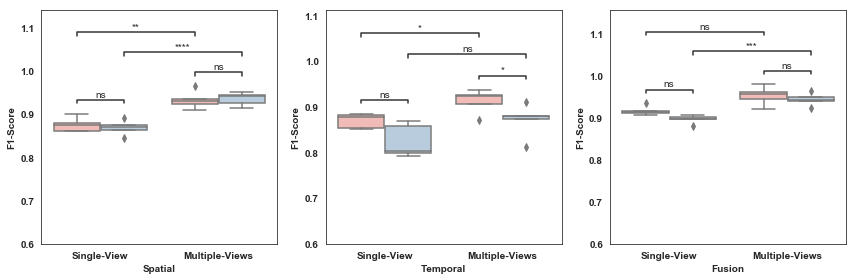

In [47]:
## No Eye Contact
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.set_style("white")
# plt.ylim(0.6, 1)
### Spatial (RGB)

noEC_Single_cc = pd.DataFrame({'class' : np.repeat('TD',len(CC_noEC_f1score_five_fold_single_view_RGB)),'Spatial' : np.repeat('Single-View',len(CC_noEC_f1score_five_fold_single_view_RGB)),'F1-Score': CC_noEC_f1score_five_fold_single_view_RGB})
noEC_Multiple_cc= pd.DataFrame({'class' : np.repeat('TD',len(CC_noEC_f1score_five_fold_multiple_view_RGB)),'Spatial' : np.repeat('Multiple-Views',len(CC_noEC_f1score_five_fold_multiple_view_RGB)),'F1-Score': CC_noEC_f1score_five_fold_multiple_view_RGB})
noEC_Single_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_noEC_f1score_five_fold_single_view_RGB)),'Spatial' : np.repeat('Single-View',len(ASD_noEC_f1score_five_fold_single_view_RGB)),'F1-Score': ASD_noEC_f1score_five_fold_single_view_RGB})
noEC_Multiple_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_noEC_f1score_five_fold_multiple_view_RGB)),'Spatial' : np.repeat('Multiple-Views',len(ASD_noEC_f1score_five_fold_multiple_view_RGB)),'F1-Score': ASD_noEC_f1score_five_fold_multiple_view_RGB})
data =pd.concat([noEC_Single_cc,noEC_Multiple_cc,noEC_Single_asd,noEC_Multiple_asd])
sns.boxplot(x='Spatial', y='F1-Score',data =data, ax=axs[0],hue="class",palette="Pastel1")
axs[0].set_ylim(0.6, 1)
# Set the font weight to bold for all text elements
for item in ([axs[0].xaxis.label, axs[0].yaxis.label] +
             axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[0],
    data = data,
    x = 'Spatial',
    y = 'F1-Score',
    hue="class",
    box_pairs=[
        (('Single-View',"ASD"),('Multiple-Views',"ASD")),(('Single-View',"TD"),('Multiple-Views',"TD")),
        (('Single-View',"ASD"),('Single-View',"TD")),(('Multiple-Views',"ASD"),('Multiple-Views',"TD")),

    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Temporal (FLOW)
sns.set_style("white")

noEC_Single_cc = pd.DataFrame({'class' : np.repeat('TD',len(CC_noEC_f1score_five_fold_single_view_flow)),'Temporal' : np.repeat('Single-View',len(CC_noEC_f1score_five_fold_single_view_flow)),'F1-Score': CC_noEC_f1score_five_fold_single_view_flow})
noEC_Multiple_cc= pd.DataFrame({'class' : np.repeat('TD',len(CC_noEC_f1score_five_fold_multiple_view_flow)),'Temporal' : np.repeat('Multiple-Views',len(CC_noEC_f1score_five_fold_multiple_view_flow)),'F1-Score': CC_noEC_f1score_five_fold_multiple_view_flow})
noEC_Single_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_noEC_f1score_five_fold_single_view_flow)),'Temporal' : np.repeat('Single-View',len(ASD_noEC_f1score_five_fold_single_view_flow)),'F1-Score': ASD_noEC_f1score_five_fold_single_view_flow})
noEC_Multiple_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_noEC_f1score_five_fold_multiple_view_flow)),'Temporal' : np.repeat('Multiple-Views',len(ASD_noEC_f1score_five_fold_multiple_view_flow)),'F1-Score': ASD_noEC_f1score_five_fold_multiple_view_flow})
data =pd.concat([noEC_Single_cc,noEC_Multiple_cc,noEC_Single_asd,noEC_Multiple_asd])
sns.boxplot(x='Temporal', y='F1-Score',data =data, ax=axs[1],hue="class",palette="Pastel1")
axs[1].set_ylim(0.6, 1)
# Set the font weight to bold for all text elements
for item in ([axs[1].xaxis.label, axs[1].yaxis.label] +
             axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[1],
    data = data,
    x = 'Temporal',
    y = 'F1-Score',
    hue="class",
    box_pairs=[
        (('Single-View',"ASD"),('Multiple-Views',"ASD")),(('Single-View',"TD"),('Multiple-Views',"TD")),
        (('Single-View',"ASD"),('Single-View',"TD")),(('Multiple-Views',"ASD"),('Multiple-Views',"TD")),

    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
### Fusion
sns.set_style("white")

noEC_Single_cc = pd.DataFrame({'class' : np.repeat('TD',len(CC_noEC_f1score_five_fold_single_view_fusion)),'Fusion' : np.repeat('Single-View',len(CC_noEC_f1score_five_fold_single_view_fusion)),'F1-Score': CC_noEC_f1score_five_fold_single_view_fusion})
noEC_Multiple_cc= pd.DataFrame({'class' : np.repeat('TD',len(CC_noEC_f1score_five_fold_multiple_view_fusion)),'Fusion' : np.repeat('Multiple-Views',len(CC_noEC_f1score_five_fold_multiple_view_fusion)),'F1-Score': CC_noEC_f1score_five_fold_multiple_view_fusion})
noEC_Single_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_noEC_f1score_five_fold_single_view_fusion)),'Fusion' : np.repeat('Single-View',len(ASD_noEC_f1score_five_fold_single_view_fusion)),'F1-Score': ASD_noEC_f1score_five_fold_single_view_fusion})
noEC_Multiple_asd = pd.DataFrame({'class' : np.repeat('ASD',len(ASD_noEC_f1score_five_fold_multiple_view_fusion)),'Fusion' : np.repeat('Multiple-Views',len(ASD_noEC_f1score_five_fold_multiple_view_fusion)),'F1-Score': ASD_noEC_f1score_five_fold_multiple_view_fusion})
data =pd.concat([noEC_Single_cc,noEC_Multiple_cc,noEC_Single_asd,noEC_Multiple_asd])
sns.boxplot(x='Fusion', y='F1-Score',data =data, ax=axs[2],hue="class",palette="Pastel1")
axs[2].set_ylim(0.6, 1)
# Set the font weight to bold for all text elements
for item in ([axs[2].xaxis.label, axs[2].yaxis.label] +
             axs[2].get_xticklabels() + axs[2].get_yticklabels()):
    item.set_fontweight('bold')
    item.set_fontsize(10)

statannot.add_stat_annotation(
    axs[2],
    data = data,
    x = 'Fusion',
    y = 'F1-Score',
    hue="class",
    box_pairs=[
        (('Single-View',"ASD"),('Multiple-Views',"ASD")),(('Single-View',"TD"),('Multiple-Views',"TD")),
        (('Single-View',"ASD"),('Single-View',"TD")),(('Multiple-Views',"ASD"),('Multiple-Views',"TD")),

    ],
    test="t-test_paired",
    text_format="star",
    loc="inside",
)
# Hide legend for each subplot
for ax in axs:
    ax.legend_.remove()
    
# handles, labels = axs[0].get_legend_handles_labels()

# fig.legend(handles, labels,loc='upper center', bbox_to_anchor=(1.03, 1), shadow=True)

plt.tight_layout()
plt.savefig(fname="ASDTD_noEC_Stats_F1_performancefigure.pdf",dpi=330)
